# Complaints Evaluated by the Commission on Police Practices

In 2020, voter-approved Measure B created a new independent Commission on Police Practices (CPP) that replaced the Community Review Board on Police Practices (CRB). The CPP independently investigates officer-involved shootings, in-custody deaths, & other significant incidents in a process that is transparent and accountable to the community. The CPP also evaluates SDPD policies, practices, training, and protocols. This dataset includes all cases the CPP reviewed and closed out since the beginning of FY 2019.

The mission of the Commission is to hold law enforcement accountable to the community and to increase community trust in law enforcement, resulting in increased safety for both the community and law enforcement. To learn more, visit sandiego.gov/cpp/about

Each case in this dataset is identified by a unique case id and case number. A single case may involve multiple allegations and multiple officers. In the FY2019 file, each row represents one allegation and finding per officer in the complaint. Each officer named in the complaint is assigned an anonymous person id in the pid field that is unique for that case id. Starting in FY2020, cases and allegation are in separate files that can be joined on the id and case_number fields.

The body worn camera details file included with this dataset lists each officer (pid) per complaint and whether that officer had a body worn camera on or off during the incident under review.


##  Import Libraries

In [1]:
!pip install mysql-connector-python


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install sweetviz


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import requests
import pandas as pd
import time
from sqlalchemy import create_engine
import os
from bs4 import BeautifulSoup
import csv
import mysql.connector
import getpass
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sw

# Data Aquisition

https://data.sandiego.gov/datasets/crb-cases/

In [4]:
# Set the URL for the page with the download links
url = 'https://data.sandiego.gov/datasets/crb-cases/'

# Set the folder path to store the CSV files
folder_path = 'C:/Users/andre/OneDrive/ADS599_Capstone/'   # Replace with the desired folder path

# Create the folder if it doesn't exist
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Fetch the HTML content
response = requests.get(url, verify=False)
if response.status_code == 200:
    html_content = response.text

    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all <paper-button> elements with the class "resource-table-button"
    button_elements = soup.find_all('paper-button', class_='resource-table-button')

    # Extract the download links
    download_links = []
    for button in button_elements:
        # Get the "property" attribute value
        property_value = button.get('property')

        # Check if it's the download link button
        if property_value == 'dcat:accessURL':
            # Get the URL from the parent <a> tag
            url = button.parent['href']
            download_links.append(url)

    # Download and save each CSV file
    for link in download_links:
        # Set the filename based on the last part of the URL
        file_name = link.split('/')[-1]

        # Fetch the CSV data
        response = requests.get(link)
        if response.status_code == 200:
            csv_data = response.content

            # Save the CSV file to the folder
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'wb') as file:
                file.write(csv_data)
            print(f"CSV file saved to: {file_path}")
        else:
            print(f"Failed to fetch the CSV file: {link}")
else:
    print("Failed to fetch the HTML content.")


CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_cases_fy2022_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_allegations_fy2022_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_cases_bwc_fy2022_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_cases_fy2021_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_allegations_fy2021_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_cases_bwc_fy2021_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_cases_fy2020_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_allegations_fy2020_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_cases_bwc_fy2020_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_cases_fy19_datasd.csv
CSV file saved to: C:/Users/andre/OneDrive/ADS599_Capstone/crb_cases_bwc_fy19_datasd.csv
CSV file save

In [8]:
# Set the MySQL database connection details
host = 'localhost'  # Replace with your MySQL host
user = 'root'  # Replace with your MySQL username
password = getpass.getpass(prompt='Password:',stream=None)  # Replace with your MySQL password

In [10]:
# Set the folder path containing the CSV files
folder_path = 'C:/Users/andre/OneDrive/ADS599_Capstone/'  # Replace with the folder path where CSV files are stored

# Create a MySQL database connection
cnx = mysql.connector.connect(host=host, user=user, password=password)
cursor = cnx.cursor()

# Create the 'crb' database if it doesn't exist
create_database_query = 'CREATE DATABASE IF NOT EXISTS crb'
cursor.execute(create_database_query)

In [11]:
# Use the 'crb' database
use_database_query = 'USE crb'
cursor.execute(use_database_query)

In [12]:
# Fetch the list of CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Iterate over each CSV file and create a table in the 'crb' database
for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    table_name = csv_file[:-4]  # Remove the '.csv' extension to use it as the table name

    # Read the CSV file
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)

        # Read the header row to extract the column names
        header_row = next(csv_reader)
        column_names = [col.strip() for col in header_row]  # Remove leading/trailing spaces

        # Initialize a dictionary to store the maximum lengths for each column
        max_lengths = {col: 0 for col in column_names}

        # Iterate over each row to determine the maximum length for each column
        for row in csv_reader:
            for col, value in zip(column_names, row):
                value_length = len(value.strip())  # Get the length of the value without leading/trailing spaces
                max_lengths[col] = max(max_lengths[col], value_length)

        # Generate the CREATE TABLE query with the appropriate column lengths
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ('
        for col in column_names:
            column_length = max_lengths[col] + 10  # Add additional buffer to the maximum length
            create_table_query += f'`{col}` VARCHAR({column_length}), '
        create_table_query = create_table_query.rstrip(', ') + ')'

        # Create the table in the 'crb' database
        cursor.execute(create_table_query)

        # Reset the file pointer to the beginning of the CSV file
        file.seek(0)

        # Skip the header row
        next(csv_reader)

        # Iterate over each row and insert into the table
        for row in csv_reader:
            insert_query = f'INSERT INTO `{table_name}` VALUES ({",".join("%s" for _ in row)})'
            values = [value.strip() for value in row]

            cursor.execute(insert_query, values)

# Commit the changes and close the database connection
cnx.commit()
cursor.close()

True

In [84]:
tables = pd.DataFrame(pd.read_sql('Show Tables', cnx))
tables

,Tables_in_crb
0,crb_allegations_fy2020_datasd
1,crb_allegations_fy2021_datasd
2,crb_allegations_fy2022_datasd
3,crb_cases_bwc_fy19_datasd
4,crb_cases_bwc_fy2020_datasd
5,crb_cases_bwc_fy2021_datasd
6,crb_cases_bwc_fy2022_datasd
7,crb_cases_fy19_datasd
8,crb_cases_fy2020_datasd
9,crb_cases_fy2021_datasd


The dictionary explains what each of the variables are in the data sets.  We'll pull the list from the database here.

In [85]:
dict_df = pd.DataFrame(pd.read_sql('SELECT * FROM dictionary', cnx))
dict_df

,﻿field,description,possible_values
0,id,Case id,
1,case_number,Case number,
2,team,CRB Team number,
3,date_assigned,Date assigned to CRB,
4,date_completed,Date CRB team completed case,
...,...,...,...
115,unanimous_vote,Whether vote was unanimous,"NO, YES"
116,pd_division,SDPD division where incident occurred,
117,crb_viewed_bwc,Whether BWC video was used in case review,
118,complainant_race,Race of complainant,


For our effort, we are most interested in any case specific data.  So we will do a query that pulls the id, case_number, team, allegation, ia_finding, crb_decision, changes, unanimous_vote, pd_division, crb_viewed_bwc, complainant_race, and complainant_gender columns from the data.  We'll start with doing this by year.

Note: fy19 is the first year of reporting.  The data here is combined into one table, so no joining is required.

In [86]:
fy19 = pd.DataFrame(pd.read_sql("""SELECT crb_cases_fy19_datasd.id, 
                                crb_cases_fy19_datasd.case_number,
                                crb_cases_fy19_datasd.allegation,
                                crb_cases_fy19_datasd.ia_finding,
                                crb_cases_fy19_datasd.crb_decision,
                                crb_cases_fy19_datasd.unanimous_vote,
                                crb_cases_fy19_datasd.date_assigned,
                                crb_Cases_fy19_datasd.date_presented,
                                crb_cases_fy19_datasd.pd_division,
                                crb_cases_fy19_datasd.complainant_race,
                                crb_cases_fy19_datasd.complainant_gender,
                                crb_cases_fy19_datasd.changes
                                FROM crb_cases_fy19_datasd
                                ;""", cnx))

fy19.head()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,complainant_race,complainant_gender,changes
0,19-59,2018-0182,ARREST,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO
1,19-59,2018-0182,FORCE,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO
2,19-59,2018-0182,OF1 PROCEDURE,S,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO
3,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO
4,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO


In [87]:
fy20 = pd.DataFrame(pd.read_sql("""SELECT crb_allegations_fy2020_datasd.id, 
                                crb_allegations_fy2020_datasd.case_number,
                                crb_allegations_fy2020_datasd.allegation,
                                crb_allegations_fy2020_datasd.ia_finding,
                                crb_allegations_fy2020_datasd.crb_decision,
                                crb_allegations_fy2020_datasd.unanimous_vote,
                                crb_cases_fy2020_datasd.date_assigned,
                                crb_Cases_fy2020_datasd.date_presented,
                                crb_cases_fy2020_datasd.pd_division,
                                crb_cases_fy2020_datasd.crb_viewed_bwc,
                                crb_cases_fy2020_datasd.complainant_race,
                                crb_cases_fy2020_datasd.complainant_gender,
                                crb_cases_fy2020_datasd.changes
                                FROM crb_allegations_fy2020_datasd
                                JOIN crb_cases_fy2020_datasd ON crb_allegations_fy2020_datasd.id = crb_cases_fy2020_datasd.id
                                ;""", cnx))

fy20.head()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,crb_viewed_bwc,complainant_race,complainant_gender,changes
0,20-29,2019-0130,OIS,WP,A,YES,2019-11-05,2020-03-10,SOUTHEASTERN,YES,W,M,NO
1,20-29,2019-0130,OIS,WP,A,YES,2019-11-05,2020-03-10,SOUTHEASTERN,YES,W,M,NO
2,20-29,2019-0130,OIS,WP,A,YES,2019-11-05,2020-03-10,SOUTHEASTERN,YES,W,M,NO
3,20-29,2019-0130,OIS,WP,A,YES,2019-11-05,2020-03-10,SOUTHEASTERN,YES,W,M,NO
4,20-29,2019-0130,OIS,WP,A,YES,2019-11-05,2020-03-10,SOUTHEASTERN,YES,W,M,NO


In [88]:
fy21 = pd.DataFrame(pd.read_sql("""SELECT crb_allegations_fy2021_datasd.id, 
                                crb_allegations_fy2021_datasd.case_number,
                                crb_allegations_fy2021_datasd.allegation,
                                crb_allegations_fy2021_datasd.ia_finding,
                                crb_allegations_fy2021_datasd.crb_decision,
                                crb_allegations_fy2021_datasd.unanimous_vote,
                                crb_cases_fy2021_datasd.date_assigned,
                                crb_Cases_fy2021_datasd.date_presented,
                                crb_cases_fy2021_datasd.pd_division,
                                crb_cases_fy2021_datasd.crb_viewed_bwc,
                                crb_cases_fy2021_datasd.complainant_race,
                                crb_cases_fy2021_datasd.complainant_gender,
                                crb_cases_fy2021_datasd.changes
                                FROM crb_allegations_fy2021_datasd
                                JOIN crb_cases_fy2021_datasd ON crb_allegations_fy2021_datasd.id = crb_cases_fy2021_datasd.id
                                ;""", cnx))

fy21.head()


,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,crb_viewed_bwc,complainant_race,complainant_gender,changes
0,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO
1,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO
2,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO
3,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO
4,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO


In [89]:
fy22 = pd.DataFrame(pd.read_sql("""SELECT crb_allegations_fy2022_datasd.id, 
                                crb_allegations_fy2022_datasd.case_number,
                                crb_allegations_fy2022_datasd.allegation,
                                crb_allegations_fy2022_datasd.ia_finding,
                                crb_allegations_fy2022_datasd.crb_decision,
                                crb_allegations_fy2022_datasd.unanimous_vote,
                                crb_cases_fy2022_datasd.date_assigned,
                                crb_cases_fy2022_datasd.date_presented,
                                crb_cases_fy2022_datasd.pd_division,
                                crb_cases_fy2022_datasd.crb_viewed_bwc,
                                crb_cases_fy2022_datasd.complainant_race,
                                crb_cases_fy2022_datasd.complainant_gender,
                                crb_cases_fy2022_datasd.changes
                                FROM crb_allegations_fy2022_datasd
                                JOIN crb_cases_fy2022_datasd ON crb_allegations_fy2022_datasd.id = crb_cases_fy2022_datasd.id
                                ;""", cnx))

fy22.head()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,crb_viewed_bwc,complainant_race,complainant_gender,changes
0,22-01,2019-0241,PROCEDURE,NS,A,YES,2019-09-05,2021-07-13,SOUTHEASTERN,YES,B,M,YES
1,22-01,2019-0241,PROCEDURE,NS,A,YES,2019-09-05,2021-07-13,SOUTHEASTERN,YES,B,M,YES
2,22-01,2019-0241,PROCEDURE,NS,A,YES,2019-09-05,2021-07-13,SOUTHEASTERN,YES,B,M,YES
3,22-01,2019-0241,PROCEDURE,NS,A,YES,2019-09-05,2021-07-13,SOUTHEASTERN,YES,B,M,YES
4,22-01,2019-0241,PROCEDURE,NS,A,YES,2019-09-05,2021-07-13,SOUTHEASTERN,YES,B,M,YES


In [90]:
allyrs = pd.concat([fy19, fy20, fy21, fy22], axis=0)

allyrs = allyrs.reset_index(drop=True)
allyrs.head()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,complainant_race,complainant_gender,changes,crb_viewed_bwc
0,19-59,2018-0182,ARREST,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
1,19-59,2018-0182,FORCE,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
2,19-59,2018-0182,OF1 PROCEDURE,S,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
3,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN
4,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN


In [91]:
allyrs.tail()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,complainant_race,complainant_gender,changes,crb_viewed_bwc
63697,22-99,2021-0304,FORCE,E,A/C,YES,2021-10-18,2022-04-26,WESTERN,B,M,NO,YES
63698,22-99,2021-0304,FORCE,E,A/C,YES,2021-10-18,2022-04-26,WESTERN,B,M,NO,YES
63699,22-99,2021-0304,FORCE,E,A/C,YES,2021-10-18,2022-04-26,WESTERN,B,M,NO,YES
63700,22-99,2021-0304,FORCE,E,A/C,YES,2021-10-18,2022-04-26,WESTERN,B,M,NO,YES
63701,22-99,2021-0304,FORCE,E,A/C,YES,2021-10-18,2022-04-26,WESTERN,B,M,NO,YES


# Data Cleaning

Now that we've pulled data for each year from our database and combined into one database, we'll start processing and cleaning the data

In [92]:
allyrs.head()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,complainant_race,complainant_gender,changes,crb_viewed_bwc
0,19-59,2018-0182,ARREST,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
1,19-59,2018-0182,FORCE,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
2,19-59,2018-0182,OF1 PROCEDURE,S,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
3,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN
4,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN


In [93]:
fy21.head()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,crb_viewed_bwc,complainant_race,complainant_gender,changes
0,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO
1,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO
2,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO
3,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO
4,21-01,2019-0671,FORCE,S,A,YES,2020-05-06,2020-07-28,MID-CITY,YES,B,M,NO


In [94]:
#Inspect the dataframe
allyrs.dtypes

id                    object
case_number           object
allegation            object
ia_finding            object
crb_decision          object
unanimous_vote        object
date_assigned         object
date_presented        object
pd_division           object
complainant_race      object
complainant_gender    object
changes               object
crb_viewed_bwc        object
dtype: object

In [95]:
#Total number of cases from 2019 to 2022
len(allyrs)

63702

In [96]:
allyrs.isna().sum()

id                       0
case_number              0
allegation               0
ia_finding               0
crb_decision             0
unanimous_vote           0
date_assigned            0
date_presented           0
pd_division              0
complainant_race         0
complainant_gender       0
changes                  0
crb_viewed_bwc        1278
dtype: int64

In [ ]:
from datetime import datetime

dfs = [fy19, fy20, fy21, fy22, allyrs]

# List of date column names
date_columns = ['date_assigned', 'date_presented']

# Iterate over each DataFrame
for df in dfs:
    # Convert date columns to datetime with "YYYY-MM-DD" format
    df[date_columns] = df[date_columns].apply(pd.to_datetime, format='%Y-%m-%d')

In [98]:
allyrs.head()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,complainant_race,complainant_gender,changes,crb_viewed_bwc
0,19-59,2018-0182,ARREST,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
1,19-59,2018-0182,FORCE,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
2,19-59,2018-0182,OF1 PROCEDURE,S,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
3,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN
4,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN


In [99]:
allyrs.shape

(63702, 13)

In [100]:
allyrs.dtypes

id                    object
case_number           object
allegation            object
ia_finding            object
crb_decision          object
unanimous_vote        object
date_assigned         object
date_presented        object
pd_division           object
complainant_race      object
complainant_gender    object
changes               object
crb_viewed_bwc        object
dtype: object

In [101]:
#missing values
allyrs.isna().sum()

id                       0
case_number              0
allegation               0
ia_finding               0
crb_decision             0
unanimous_vote           0
date_assigned            0
date_presented           0
pd_division              0
complainant_race         0
complainant_gender       0
changes                  0
crb_viewed_bwc        1278
dtype: int64

In [102]:
#check for issues in the gender and race columns
allyrs['complainant_gender'].value_counts()

complainant_gender
M      35472
F      27042
UNK      792
         252
F,M       78
M,M       42
F,F       18
MM         6
Name: count, dtype: int64

In [115]:
for df in dfs:
    df['complainant_gender'] = df['complainant_gender'].replace({'M,M': 'M', 'MM': 'M', 'F,F': 'F', '': 'UNK',
                                                                     'F,M': 'UNK'})

In [116]:
allyrs['complainant_race'].value_counts()

complainant_race
B      27270
H      15786
W      11724
UNK     5280
O       2952
A        330
F        144
S        144
P         72
Name: count, dtype: int64

In [105]:
for df in dfs:
    df['complainant_race'] = df['complainant_race'].replace({'H,H': 'H', 'HH': 'H', 'B,B': 'B', 'W,W': 'W',
                                                                 'unkn': 'UNK', 'W,B': 'UNK', 'ME': 'UNK', 'NOT STATED IN THE REPORT': 'UNK',
                                                                 '': 'UNK'})

allyrs['complainant_race'].value_counts()

complainant_race
B      27270
H      15786
W      11724
UNK     5280
O       2952
A        330
F        144
S        144
P         72
Name: count, dtype: int64

In [106]:
allyrs

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,complainant_race,complainant_gender,changes,crb_viewed_bwc
0,19-59,2018-0182,ARREST,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
1,19-59,2018-0182,FORCE,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
2,19-59,2018-0182,OF1 PROCEDURE,S,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
3,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN
4,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63697,22-99,2021-0304,FORCE,E,A/C,YES,2021-10-18,2022-04-26,WESTERN,B,M,NO,YES
63698,22-99,2021-0304,FORCE,E,A/C,YES,2021-10-18,2022-04-26,WESTERN,B,M,NO,YES
63699,22-99,2021-0304,FORCE,E,A/C,YES,2021-10-18,2022-04-26,WESTERN,B,M,NO,YES
63700,22-99,2021-0304,FORCE,E,A/C,YES,2021-10-18,2022-04-26,WESTERN,B,M,NO,YES


In [107]:
allyrs['complainant_race'].value_counts()

complainant_race
B      27270
H      15786
W      11724
UNK     5280
O       2952
A        330
F        144
S        144
P         72
Name: count, dtype: int64

In [108]:
allyrs['crb_decision'].value_counts()

crb_decision
A      56730
A/C     6144
D/C      720
AC       108
Name: count, dtype: int64

In [110]:
allyrs['changes'].value_counts()

changes
NO     46020
YES    16602
        1080
Name: count, dtype: int64

# Exploratory Data Analysis

We'll being by looking at data provided each year

## Allegations by year

In [111]:
tot19 = fy19.shape[0]
tot19

1278

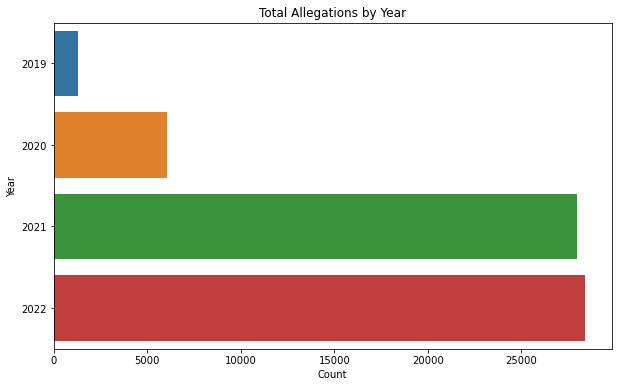

In [112]:
# Total complaints by year
tot19 = pd.DataFrame({'Count': [fy19.shape[0]]}, index=['2019'])
tot20 = pd.DataFrame({'Count': [fy20.shape[0]]}, index=['2020'])
tot21 = pd.DataFrame({'Count': [fy21.shape[0]]}, index=['2021'])
tot22 = pd.DataFrame({'Count': [fy22.shape[0]]}, index=['2022'])

tot_counts = pd.concat([tot19, tot20, tot21, tot22])

# Reset index
tot_counts.reset_index(inplace=True)
tot_counts.columns = ['Year', 'Count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=tot_counts, x='Count', y='Year')
plt.title('Total Allegations by Year')
plt.xlabel('Count')
plt.ylabel('Year')
plt.show()

## Allegations by year and gender

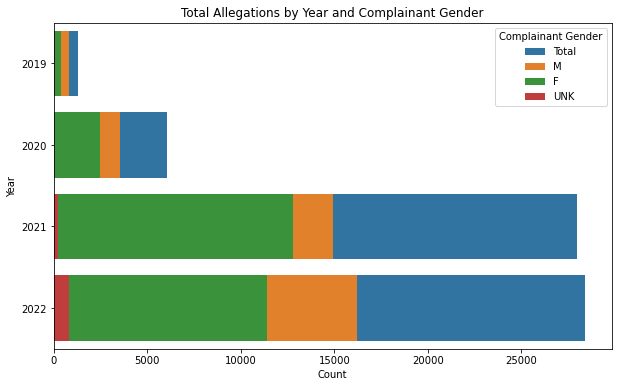

In [117]:
# Total complaints by year
tot19 = pd.DataFrame({'Year': ['2019'], 'Count': [fy19.shape[0]], 'complainant_gender': ['Total']})
tot20 = pd.DataFrame({'Year': ['2020'], 'Count': [fy20.shape[0]], 'complainant_gender': ['Total']})
tot21 = pd.DataFrame({'Year': ['2021'], 'Count': [fy21.shape[0]], 'complainant_gender': ['Total']})
tot22 = pd.DataFrame({'Year': ['2022'], 'Count': [fy22.shape[0]], 'complainant_gender': ['Total']})

tot_counts = pd.concat([tot19, tot20, tot21, tot22])

# Complainant gender counts by year
gender_counts_19 = fy19['complainant_gender'].value_counts().reset_index()
gender_counts_19['Year'] = '2019'
gender_counts_20 = fy20['complainant_gender'].value_counts().reset_index()
gender_counts_20['Year'] = '2020'
gender_counts_21 = fy21['complainant_gender'].value_counts().reset_index()
gender_counts_21['Year'] = '2021'
gender_counts_22 = fy22['complainant_gender'].value_counts().reset_index()
gender_counts_22['Year'] = '2022'

gender_counts = pd.concat([gender_counts_19, gender_counts_20, gender_counts_21, gender_counts_22])
gender_counts.columns = ['complainant_gender', 'Count', 'Year']

# Combine total complaints and gender counts
combined_counts = pd.concat([tot_counts, gender_counts])

# Create the stacked bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=combined_counts, x='Count', y='Year', hue='complainant_gender', dodge=False)
plt.title('Total Allegations by Year and Complainant Gender')
plt.xlabel('Count')
plt.ylabel('Year')
plt.legend(title='Complainant Gender')
plt.show()


## Allegations by Race


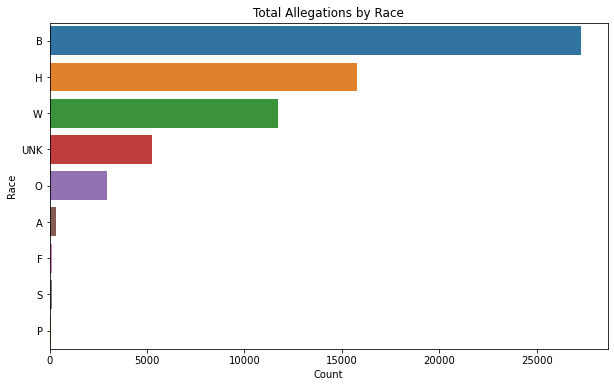

In [114]:
tot = pd.DataFrame(allyrs['complainant_race'].value_counts().reset_index())
tot.columns = ['race', 'count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=tot, x='count', y='race')
plt.title('Total Allegations by Race')
plt.xlabel('Count')
plt.ylabel('Race')
plt.show()


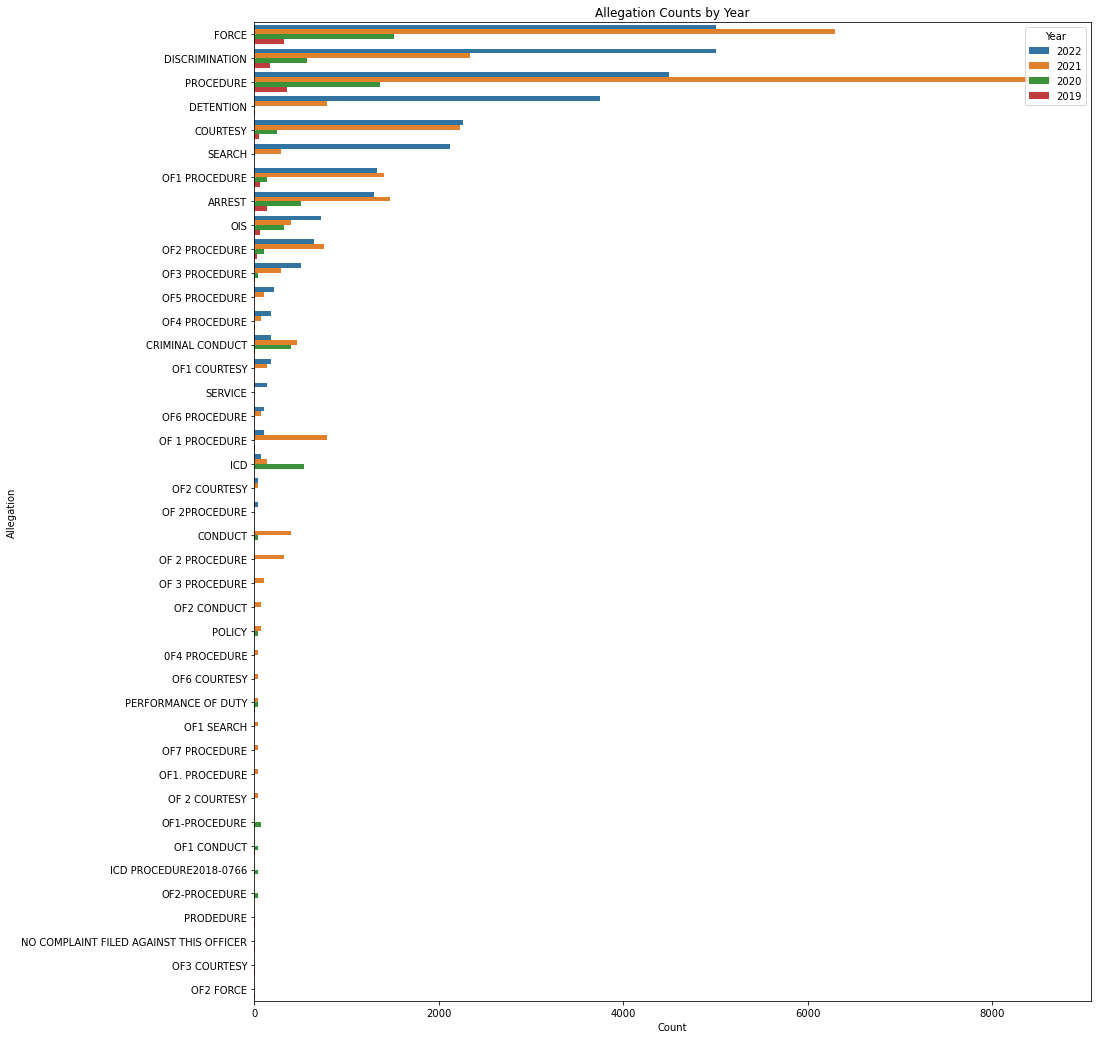

In [118]:
# Calculate the allegation counts for each year
alleg_count_22 = fy22['allegation'].value_counts()
alleg_count_21 = fy21['allegation'].value_counts()
alleg_count_20 = fy20['allegation'].value_counts()
alleg_count_19 = fy19['allegation'].value_counts()

# Combine the counts into a single DataFrame
alleg_counts = pd.concat([alleg_count_22, alleg_count_21, alleg_count_20, alleg_count_19], axis=1)
alleg_counts.columns = ['2022', '2021', '2020', '2019']

# Reshape the data into a long format
alleg_counts_long = alleg_counts.stack().reset_index()
alleg_counts_long.columns = ['Allegation', 'Year', 'Count']

# Create the bar plot
plt.figure(figsize=(15, 18))
sns.barplot(data=alleg_counts_long, x='Count', y='Allegation', hue='Year')
plt.title('Allegation Counts by Year')
plt.xlabel('Count')
plt.ylabel('Allegation')
plt.legend(title='Year')
plt.show()


## IA and CRB findings

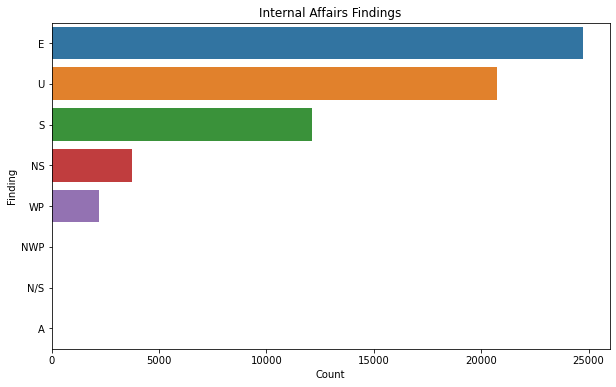

In [119]:
tot = pd.DataFrame(allyrs['ia_finding'].value_counts().reset_index())
tot.columns = ['ia_finding', 'count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=tot, x='count', y='ia_finding')
plt.title('Internal Affairs Findings')
plt.xlabel('Count')
plt.ylabel('Finding')
plt.show()


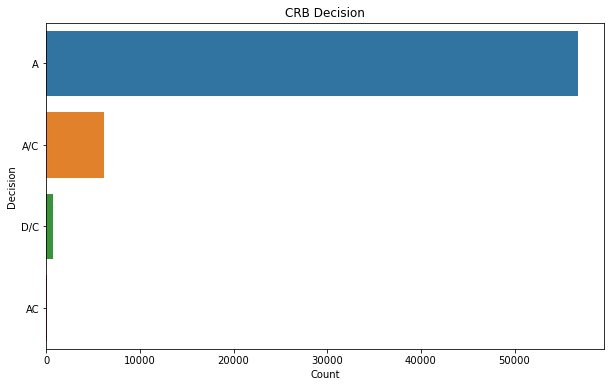

In [120]:
tot = pd.DataFrame(allyrs['crb_decision'].value_counts().reset_index())
tot.columns = ['crb_decision', 'count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=tot, x='count', y='crb_decision')
plt.title('CRB Decision')
plt.xlabel('Count')
plt.ylabel('Decision')
plt.show()

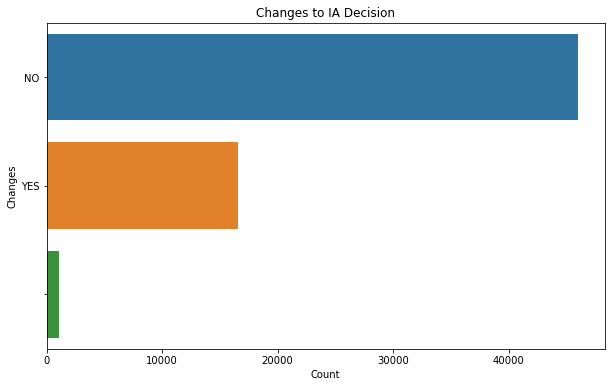

In [121]:
tot = pd.DataFrame(allyrs['changes'].value_counts().reset_index())
tot.columns = ['changes', 'count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=tot, x='count', y='changes')
plt.title('Changes to IA Decision')
plt.xlabel('Count')
plt.ylabel('Changes')
plt.show()

# Feature Engineering

In [122]:
allyrs.head()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,complainant_race,complainant_gender,changes,crb_viewed_bwc
0,19-59,2018-0182,ARREST,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
1,19-59,2018-0182,FORCE,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
2,19-59,2018-0182,OF1 PROCEDURE,S,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN
3,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN
4,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN


In [123]:
crb_disagree = allyrs[allyrs['crb_decision'] == 'D/C']
crb_disagree

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,complainant_race,complainant_gender,changes,crb_viewed_bwc
28,19-46,2018-0257,PROCEDURE,NS,D/C,NO,12/12/18,4/23/19,EASTERN,B,M,YES,NaN
61,19-34,2017-0603,ARREST,E,D/C,NO,10/17/18,2/26/19,SOUTHEASTERN,B,M,NO,NaN
154,19-14,2017-0255,FORCE,E,D/C,NO,5/7/18,10/30/18,SOUTHERN,W,M,NO,NaN
155,19-14,2017-0255,PROCEDURE,U,D/C,NO,5/7/18,10/30/18,SOUTHERN,W,M,NO,NaN
174,19-08,2018-0046,ARREST,E,D/C,NO,6/19/18,9/11/18,CENTRAL,B,M,NO,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63565,22-96,2021-0327,FORCE,U,D/C,YES,2021-11-08,2022-04-12,CENTRAL,H,F,YES,YES
63566,22-96,2021-0327,FORCE,U,D/C,YES,2021-11-08,2022-04-12,CENTRAL,H,F,YES,YES
63567,22-96,2021-0327,FORCE,U,D/C,YES,2021-11-08,2022-04-12,CENTRAL,H,F,YES,YES
63568,22-96,2021-0327,FORCE,U,D/C,YES,2021-11-08,2022-04-12,CENTRAL,H,F,YES,YES


In [124]:
# Create the 'misconduct' column
allyrs['misconduct'] = ((allyrs['ia_finding'] == 'S') | (allyrs['crb_decision'].isin(['D/C']))).astype(int)

allyrs.head()

,id,case_number,allegation,ia_finding,crb_decision,unanimous_vote,date_assigned,date_presented,pd_division,complainant_race,complainant_gender,changes,crb_viewed_bwc,misconduct
0,19-59,2018-0182,ARREST,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN,0
1,19-59,2018-0182,FORCE,E,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN,0
2,19-59,2018-0182,OF1 PROCEDURE,S,A,YES,1/29/19,6/11/19,CENTRAL,B,M,NO,NaN,1
3,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN,0
4,19-58,2019-0152,DISCRIMINATION,U,A,YES,4/17/19,6/25/19,WESTERN,W,M,NO,NaN,0


In [125]:
len(allyrs)

63702

In [128]:
allyrs['misconduct'].value_counts()

misconduct
0    50850
1    12852
Name: count, dtype: int64

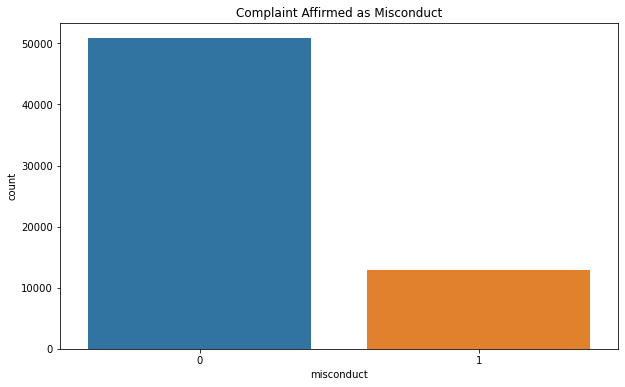

In [129]:
tot = pd.DataFrame(allyrs['misconduct'].value_counts().reset_index())
tot.columns = ['misconduct', 'count']

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=tot, x='misconduct', y='count')
plt.title('Complaint Affirmed as Misconduct')
plt.xlabel('misconduct')
plt.ylabel('count')
plt.show()